In [ ]:
!pip install PrettyTable powerlaw

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import powerlaw
import json

from prettytable import PrettyTable
from collections import defaultdict, Counter
from community import community_louvain

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, normalized_mutual_info_score

In [ ]:
# 1. LOADING DATASET:

targets = pd.read_csv('musae_facebook_target.csv')
edges = pd.read_csv('musae_facebook_edges.csv')

# 2. DATA CLEANING

# Remove duplicates
targets.drop_duplicates(subset='id', keep='first', inplace=True)

# Check for missing values and fill or drop
targets.fillna({'page_name': 'No Name', 'page_type': 'Unknown'}, inplace=True)

# Standardizing text entries
targets['page_type'] = targets['page_type'].str.title().str.strip()

# Remove duplicates
edges.drop_duplicates(inplace=True)

# Remove self-loops
edges = edges[edges['id_1'] != edges['id_2']]

# Check all edges have nodes in target
valid_ids = set(targets['id'])
edges = edges[edges['id_1'].isin(valid_ids) & edges['id_2'].isin(valid_ids)]


In [ ]:
# 3. SAVING CLEANSED DATA

targets.to_csv('cleaned_musae_facebook_target.csv', index=False)
edges.to_csv('cleaned_musae_facebook_edges.csv', index=False)

In [ ]:
# 4. DATA SAMPLING

# Sampling strategy: 10% of each page_type
sample_frac = 0.1

# Apply stratified sampling on the nodes
stratified_sample, _ = train_test_split(targets, test_size=1-sample_frac, stratify=targets['page_type'], random_state=42)

# Filter edges to only include nodes that are in the sampled node list
sampled_node_ids = set(stratified_sample['id'])
sampled_edges = edges[(edges['id_1'].isin(sampled_node_ids)) & (edges['id_2'].isin(sampled_node_ids))]

# Final sampled data properties
sampled_node_count = stratified_sample.shape[0]
sampled_edge_count = sampled_edges.shape[0]

print("Total Nodes After Sampling:", sampled_node_count)
print("Total Edges After Sampling:", sampled_edge_count)


Total Nodes After Sampling: 2247
Total Edges After Sampling: 1604


+--------------------------------+----------------------+
|            Measure             |        Value         |
+--------------------------------+----------------------+
|   Average Degree Centrality    | 0.004463382157123832 |
| Average Betweenness Centrality | 0.01030936588331712  |
|  Average Closeness Centrality  | 0.11848284276098103  |
|      Average Path Length       |  8.721715046604528   |
| Average Clustering Coefficient |  0.2483903640204774  |
+--------------------------------+----------------------+


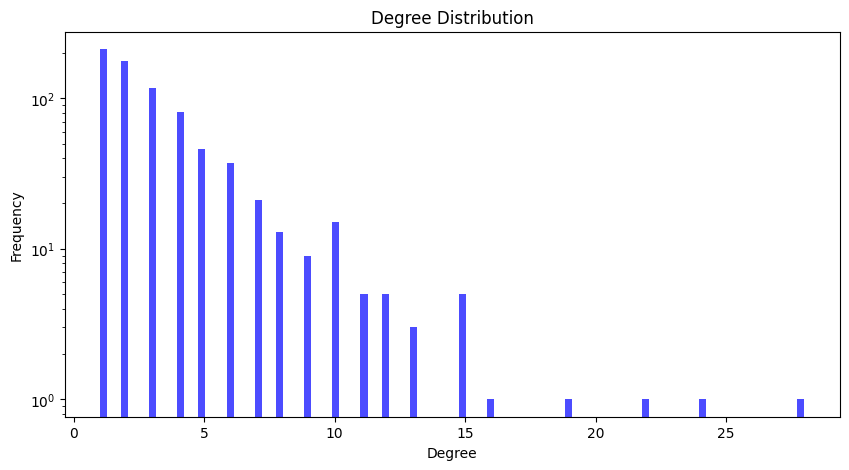

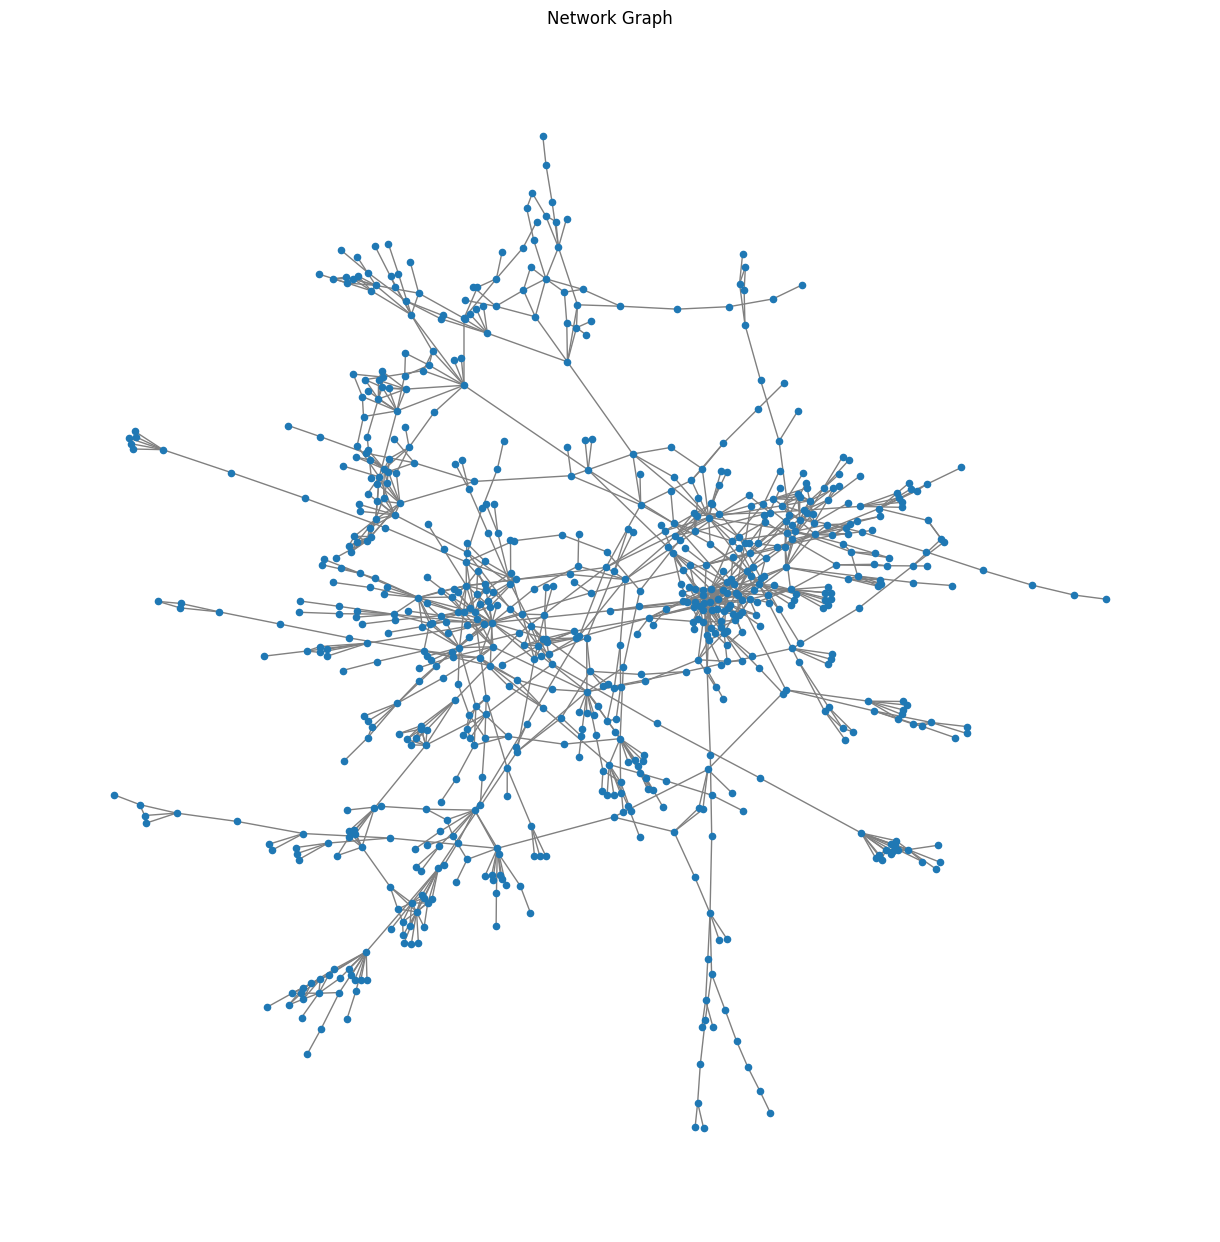

In [ ]:
# 5. NETWORK MEASURES

from prettytable import PrettyTable

# Create a graph
G_sampled = nx.Graph()
for idx, row in stratified_sample.iterrows():
    G_sampled.add_node(row['id'], category=row['page_type'])
G_sampled.add_edges_from(sampled_edges.values)


# Remove isolated nodes (nodes with no edges)
G_sampled.remove_nodes_from(list(nx.isolates(G_sampled)))

# Retreiving largest connected component
largest_cc = max(nx.connected_components(G_sampled), key=len)
subgraph = G_sampled.subgraph(largest_cc)

# Compute centrality measures
degree_centrality = nx.degree_centrality(subgraph)
betweenness_centrality = nx.betweenness_centrality(subgraph)
closeness_centrality = nx.closeness_centrality(subgraph)
# Compute average path length and clustering coefficient
average_path_length = nx.average_shortest_path_length(subgraph)
average_clustering = nx.average_clustering(subgraph)

table = PrettyTable()
table.field_names = ["Measure", "Value"]
table.add_row(["Average Degree Centrality", sum(degree_centrality.values()) / len(degree_centrality)])
table.add_row(["Average Betweenness Centrality", sum(betweenness_centrality.values()) / len(betweenness_centrality)])
table.add_row(["Average Closeness Centrality", sum(closeness_centrality.values()) / len(closeness_centrality)])
table.add_row(["Average Path Length", average_path_length])
table.add_row(["Average Clustering Coefficient", average_clustering])

print(table)


# Plotting the degree distribution of the largest connected component
degrees = [subgraph.degree(n) for n in subgraph.nodes()]
plt.figure(figsize=(10, 5))
plt.hist(degrees, bins=100, color='b', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

# Plot largest connected component
pos = nx.spring_layout(subgraph, scale=20)
plt.figure(figsize=(12, 12))
nx.draw(subgraph, pos, node_size=20, edge_color='gray', with_labels=False)
plt.title('Network Graph')
plt.show()


Calculating best minimal value for power law fit


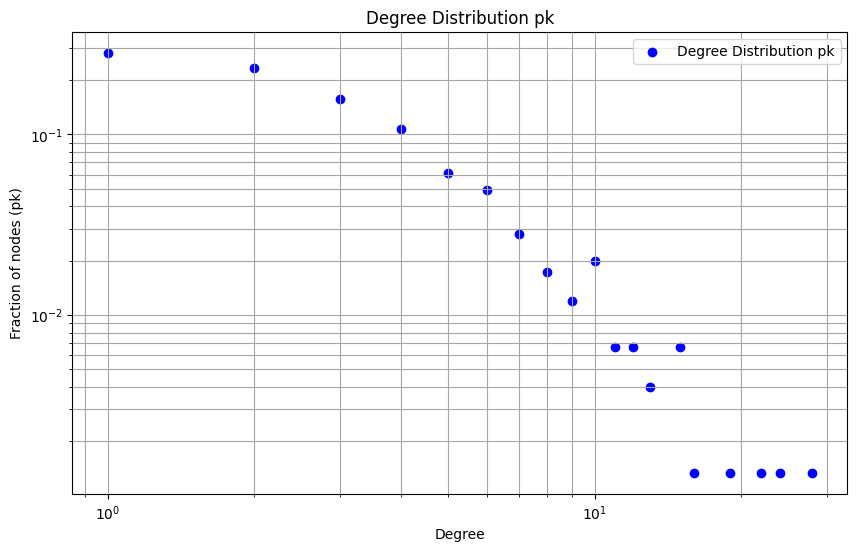

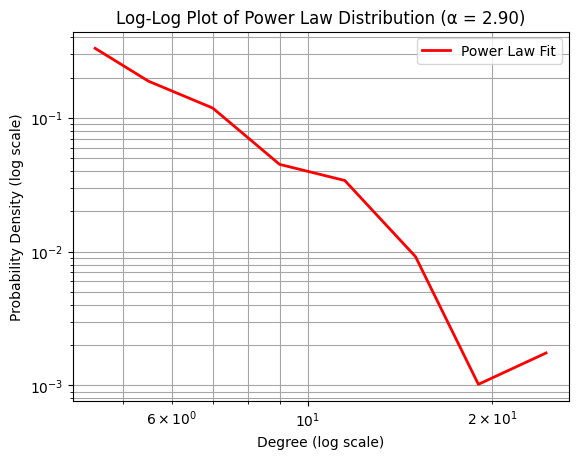

In [ ]:
# Compute degree distribution
degree_sequence = sorted([d for n, d in subgraph.degree()], reverse=True)

# Calculate pk (Fraction of nodes having degree k)
degree_counts = pd.Series(degree_sequence).value_counts().sort_index()
pk = degree_counts / degree_counts.sum()

# Fit power-law distribution
fit = powerlaw.Fit(degree_sequence, discrete=True)
alpha = fit.alpha

# Plot degree distribution using pk
plt.figure(figsize=(10, 6))
plt.scatter(pk.index, pk.values, color='b', label='Degree Distribution pk')
plt.title('Degree Distribution pk')
plt.xlabel('Degree')
plt.ylabel('Fraction of nodes (pk)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", color='0.65')
plt.legend()
plt.show()

# Plot log-log plot of power-law distribution
fig, ax = plt.subplots()
fit.plot_pdf(color='r', linewidth=2, label='Power Law Fit')
ax.set_title('Log-Log Plot of Power Law Distribution (α = {:.2f})'.format(alpha))
ax.set_xlabel('Degree (log scale)')
ax.set_ylabel('Probability Density (log scale)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which="both", ls="-", color='0.65')
ax.legend()
plt.show()

Top 5 nodes by Degree Centrality:
Node 12464: 0.03733333333333333
Node 15236: 0.032
Node 13098: 0.029333333333333333
Node 1654: 0.025333333333333333
Node 3906: 0.021333333333333333

Top 5 nodes by Closeness Centrality:
Node 15177: 0.17337031900138697
Node 20135: 0.17088174982911825
Node 12464: 0.16552637386890312
Node 15236: 0.16483516483516483
Node 11834: 0.164257555847569

Top 5 nodes by Betweenness Centrality:
Node 15177: 0.2709968888076421
Node 3906: 0.20728358414101053
Node 20135: 0.1970479706394781
Node 11507: 0.13960616591089942
Node 12464: 0.1359372046474118

Top 5 nodes by Eigenvector Centrality:
Node 12464: 0.39988132105360413
Node 15236: 0.3639174928847035
Node 1654: 0.32409828568605226
Node 18078: 0.21853215161778092
Node 11273: 0.19131717733646372

Top 5 nodes by PageRank Centrality:
Node 12464: 0.007858284057544466
Node 13098: 0.007826760485459114
Node 15236: 0.00659822600033243
Node 3906: 0.006512775024280039
Node 10503: 0.005621713201788168



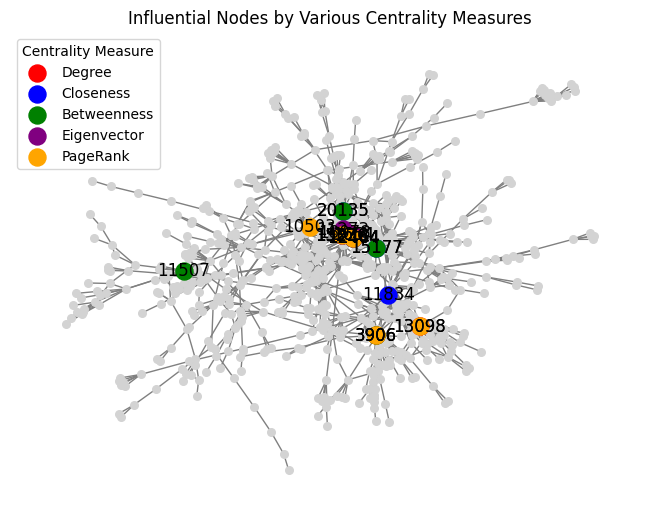

In [ ]:
# Calculate centrality measures
centrality_measures = {
    'Degree': nx.degree_centrality(subgraph),
    'Closeness': nx.closeness_centrality(subgraph),
    'Betweenness': nx.betweenness_centrality(subgraph),
    'Eigenvector': nx.eigenvector_centrality(subgraph, max_iter=1000),
    'PageRank': nx.pagerank(subgraph)
}

# Identify top 5 influential nodes based on each centrality measure
top_nodes = {measure: sorted(cent.items(), key=lambda x: x[1], reverse=True)[:5] for measure, cent in centrality_measures.items()}

# Display top nodes
for measure, nodes in top_nodes.items():
    print(f"Top 5 nodes by {measure} Centrality:")
    for node, centrality_value in nodes:
        print(f"Node {node}: {centrality_value}")
    print()

# Visualization for each centrality measure
pos = nx.spring_layout(subgraph)
colors = ['red', 'blue', 'green', 'purple', 'orange']
labels = list(centrality_measures.keys())

nx.draw(subgraph, pos, node_color='lightgrey', with_labels=False, node_size=30, edge_color='grey')

# Highlight top nodes for each centrality measure
for i, (measure, nodes) in enumerate(top_nodes.items()):
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node for node, _ in nodes],
                           node_color=colors[i], label=f'{measure}', node_size=150)
    nx.draw_networkx_labels(subgraph, pos, labels={node: str(node) for node, _ in nodes}, font_color='black')

plt.title('Influential Nodes by Various Centrality Measures')
plt.legend(title="Centrality Measure")
plt.show()

Edge with highest Betweenness Centrality: (20135, 15177) with a centrality of 0.13063


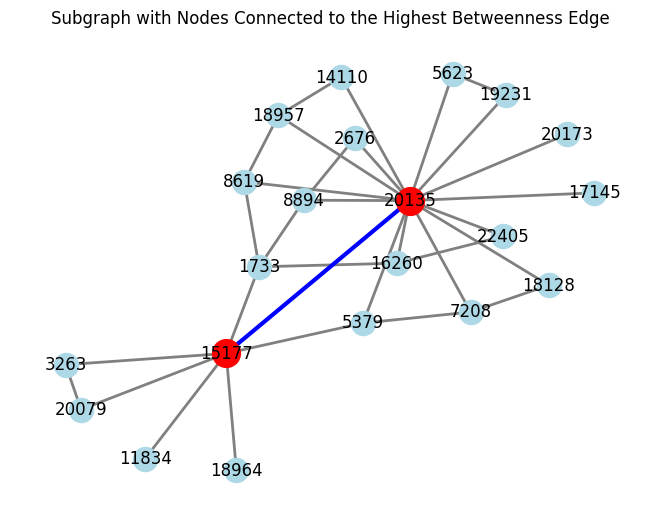

In [ ]:
# Compute edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(subgraph)

# Finding the edge with the highest betweenness centrality
highest_edge = max(edge_betweenness, key=edge_betweenness.get)
highest_centrality = edge_betweenness[highest_edge]

print(f"Edge with highest Betweenness Centrality: {highest_edge} with a centrality of {highest_centrality:.5f}")

# Get the nodes for the highest betweenness edge
node1, node2 = highest_edge

# Get neighbors of these nodes
neighbors_node1 = list(subgraph.neighbors(node1))
neighbors_node2 = list(subgraph.neighbors(node2))

# Create a subgraph including the highest edge and its neighboring nodes
nodes_to_include = set([node1, node2] + neighbors_node1 + neighbors_node2)
highest_edge_subgraph = subgraph.subgraph(nodes_to_include)

# Visualization
pos = nx.spring_layout(highest_edge_subgraph)  # Layout for good visualization

nx.draw(highest_edge_subgraph, pos, with_labels=True, node_color='lightblue', node_size=300, edge_color='gray', width=2)
nx.draw_networkx_edges(highest_edge_subgraph, pos, edgelist=[highest_edge], edge_color='blue', width=3)
nx.draw_networkx_nodes(highest_edge_subgraph, pos, nodelist=[node1, node2], node_color='red', node_size=400)

plt.title('Subgraph with Nodes Connected to the Highest Betweenness Edge')
plt.show()


In [ ]:
!pip install python-louvain


<ipython-input-13-4591eec24dd4>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


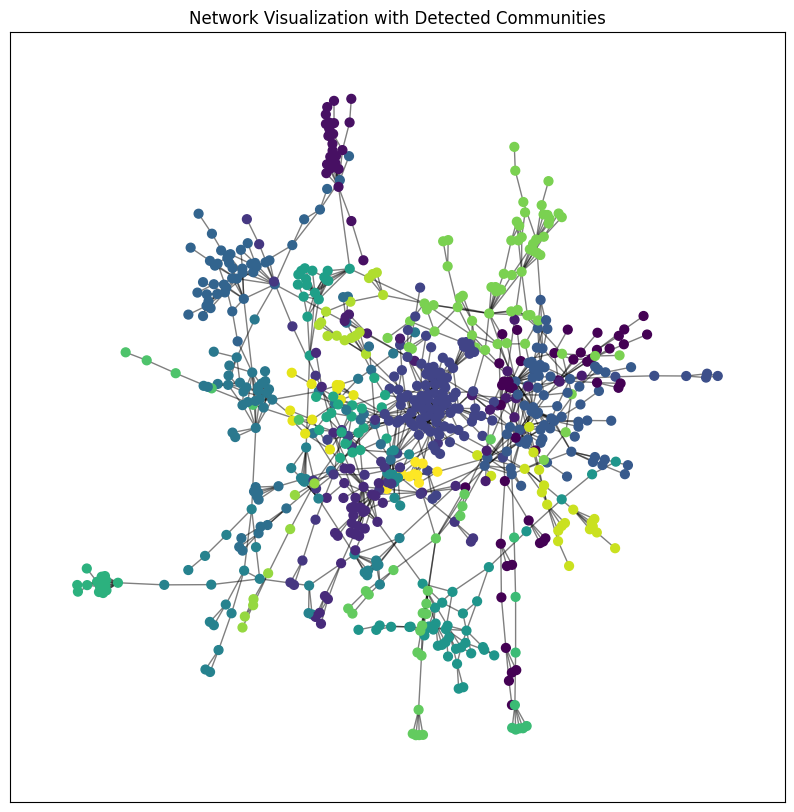

Community 0:
  Majority Category: Company
  Homogeneity (proportion of majority category): 0.67
  Total Nodes: 45
  Category Breakdown: Counter({'Company': 30, 'Tvshow': 8, 'Government': 7})
Community 1:
  Majority Category: Government
  Homogeneity (proportion of majority category): 0.54
  Total Nodes: 24
  Category Breakdown: Counter({'Government': 13, 'Politician': 11})
Community 2:
  Majority Category: Government
  Homogeneity (proportion of majority category): 0.63
  Total Nodes: 19
  Category Breakdown: Counter({'Government': 12, 'Company': 6, 'Politician': 1})
Community 3:
  Majority Category: Government
  Homogeneity (proportion of majority category): 1.00
  Total Nodes: 39
  Category Breakdown: Counter({'Government': 39})
Community 4:
  Majority Category: Company
  Homogeneity (proportion of majority category): 0.89
  Total Nodes: 27
  Category Breakdown: Counter({'Company': 24, 'Tvshow': 3})
Community 5:
  Majority Category: Government
  Homogeneity (proportion of majority ca

In [ ]:
# 6. COMMUNITY DETECTION

# Detect communities
partition = community_louvain.best_partition(subgraph)

# Visualize the detected communities
pos = nx.spring_layout(subgraph)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(subgraph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
plt.title('Network Visualization with Detected Communities')
plt.show()

ground_truth = pd.Series(stratified_sample['page_type'].values, index=stratified_sample['id']).to_dict()

# Group nodes by community and their categories
community_nodes = defaultdict(list)
for node, community in partition.items():
    category = subgraph.nodes[node].get('category', 'Unknown')
    community_nodes[community].append(category)

# Evaluate each community
for community, categories in community_nodes.items():
    # Determine the majority category
    category_count = Counter(categories)
    majority_category, majority_count = category_count.most_common(1)[0]
    homogeneity = majority_count / len(categories)

    # Print evaluation
    print(f"Community {community}:")
    print(f"  Majority Category: {majority_category}")
    print(f"  Homogeneity (proportion of majority category): {homogeneity:.2f}")
    print(f"  Total Nodes: {len(categories)}")
    print("  Category Breakdown:", category_count)


Overall Metrics for All Communities:
  Precision: 0.75
  Recall: 1.00
  F1-Score: 0.85
  Purity: 0.75


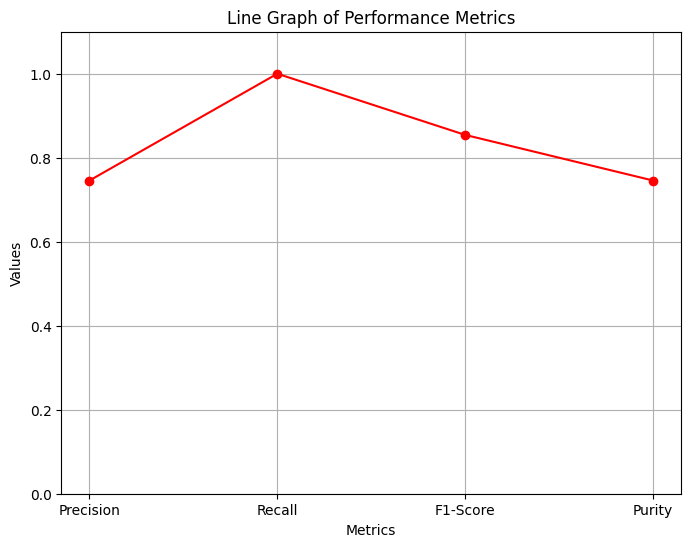

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Aggregating true and predicted labels across all nodes
all_true_binary = []
all_predicted_binary = []

for community, categories in community_nodes.items():
    # Retrieve the true categories of nodes in this community
    nodes_in_community = [node for node, comm in partition.items() if comm == community]
    true_categories = [ground_truth[node] for node in nodes_in_community if node in ground_truth]

    # Determine the majority category
    majority_category = Counter(categories).most_common(1)[0][0]

    # Extend the binary classification lists
    true_binary = [1 if category == majority_category else 0 for category in true_categories]
    predicted_binary = [1] * len(true_binary)  # Predict all as 1 (majority category)

    # Append to overall lists
    all_true_binary.extend(true_binary)
    all_predicted_binary.extend(predicted_binary)

# Calculate precision, recall, F1-score, and purity for the aggregated data
precision = precision_score(all_true_binary, all_predicted_binary, zero_division=1)
recall = recall_score(all_true_binary, all_predicted_binary, zero_division=1)
f1 = f1_score(all_true_binary, all_predicted_binary, zero_division=1)
purity = sum(all_true_binary) / len(all_true_binary) if all_true_binary else 0

# Output the calculated metrics
print("Overall Metrics for All Communities:")
print(f"  Precision: {precision:.2f}")
print(f"  Recall: {recall:.2f}")
print(f"  F1-Score: {f1:.2f}")
print(f"  Purity: {purity:.2f}")

import matplotlib.pyplot as plt

# Metrics and their values
metrics = ['Precision', 'Recall', 'F1-Score', 'Purity']
values = [precision, recall, f1, purity]

# Create the line plot
plt.figure(figsize=(8, 6))
plt.plot(metrics, values, '-o', color='red')  # Line with dots at each metric point
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Line Graph of Performance Metrics')
plt.ylim(0, 1.1)  # Set y-axis limit slightly above 1 to accommodate the max value
plt.grid(True)
plt.show()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'subgraph' is your network graph and 'partition' is the community assignment dictionary

# Convert partition dictionary to the format expected by networkx's community module
from networkx.algorithms.community import modularity as nx_modularity

# Create a dictionary where keys are community IDs and values are lists of nodes in each community
communities_dict = {}
for node, comm_id in partition.items():
    if comm_id not in communities_dict:
        communities_dict[comm_id] = []
    communities_dict[comm_id].append(node)

# List of communities required by the modularity function
communities = list(communities_dict.values())

# Calculate modularity
modularity_value = nx_modularity(subgraph, communities)

# Output the calculated modularity
print(f"Modularity: {modularity_value:.4f}")

Modularity: 0.8632


In [ ]:
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable

# Convert network measures to DataFrame
network_df = pd.DataFrame(centrality_measures)

# Create a DataFrame from subgraph node attributes
node_data = {
    'id': [],
    'page_type': []
}
for node in subgraph.nodes(data=True):
    node_data['id'].append(node[0])
    node_data['page_type'].append(node[1]['category'])
node_df = pd.DataFrame(node_data)

# Merge the DataFrames on node 'id'
full_data = pd.merge(node_df, network_df, left_on='id', right_index=True)

# Prepare data for the machine learning pipeline
X = full_data.drop(['id', 'page_type'], axis=1)
y = full_data['page_type']

# Machine Learning Pipeline
pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# classification report
report = classification_report(y_test, y_pred, output_dict=True)
table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-score", "Support"]
for key, value in report.items():
    if isinstance(value, dict):
        table.add_row([key, f"{value['precision']:.2f}", f"{value['recall']:.2f}", f"{value['f1-score']:.2f}", value['support']])
print(table)

accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}%")


+--------------+-----------+--------+----------+---------+
|    Class     | Precision | Recall | F1-score | Support |
+--------------+-----------+--------+----------+---------+
|   Company    |    0.39   |  0.32  |   0.35   |    22   |
|  Government  |    0.81   |  0.76  |   0.78   |   125   |
|  Politician  |    0.65   |  0.80  |   0.72   |    69   |
|    Tvshow    |    0.50   |  0.30  |   0.37   |    10   |
|  macro avg   |    0.59   |  0.54  |   0.56   |   226   |
| weighted avg |    0.71   |  0.71  |   0.70   |   226   |
+--------------+-----------+--------+----------+---------+
Overall Accuracy: 0.71%


In [ ]:

# Determine the majority category for each community
community_categories = {}
for node, community in partition.items():
    if community not in community_categories:
        community_categories[community] = []
    community_categories[community].append(subgraph.nodes[node]['category'])

majority_category = {community: Counter(categories).most_common(1)[0][0] for community, categories in community_categories.items()}

# Assigniging the majority category to each node based on its community for comparison
community_labels = [majority_category[partition[node]] for node in subgraph.nodes()]
ground_truth_labels = [subgraph.nodes[node]['category'] for node in subgraph.nodes()]

# Calculate NMI
nmi_score = normalized_mutual_info_score(ground_truth_labels, community_labels)
print("Normalized Mutual Information (NMI) Score:", nmi_score)


Normalized Mutual Information (NMI) Score: 0.36486352655826426


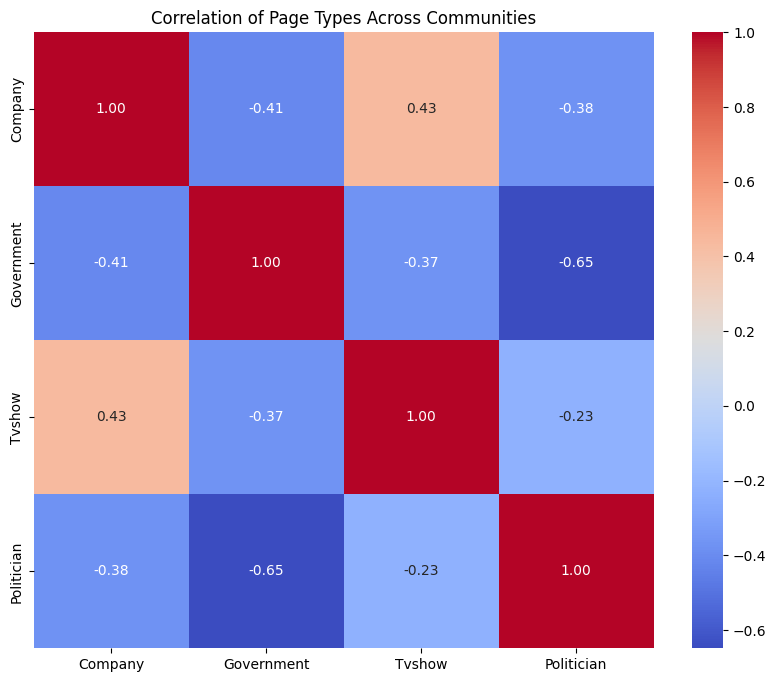

In [ ]:
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter

# Group nodes by community and their page types
community_page_types = defaultdict(list)
for node in subgraph.nodes():
    community_id = partition[node]
    page_type = subgraph.nodes[node]['category']
    community_page_types[community_id].append(page_type)

# Create a DataFrame to analyze the distribution of page types across communities
data = []
for community, types in community_page_types.items():
    type_counts = Counter(types)
    data.append(type_counts)

df = pd.DataFrame(data)
df.fillna(0, inplace=True)

# Normalize the data by row to compare proportions instead of absolute counts
df_normalized = df.div(df.sum(axis=1), axis=0)

# Calculate the correlation matrix to see how page types correlate across communities
correlation_matrix = df_normalized.corr()

# Plotting the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Page Types Across Communities')
plt.show()
